In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

**Exploratory Data Analysis**

In [3]:
df = pd.read_csv('https://richardson.byu.edu/220/OnlineNewsPopularity.csv')
df.head()
df.columns = df.columns.str.strip()
df.columns

Index(['url', 'timedelta', 'n_tokens_title', 'n_tokens_content',
       'n_unique_tokens', 'n_non_stop_words', 'n_non_stop_unique_tokens',
       'num_hrefs', 'num_self_hrefs', 'num_imgs', 'num_videos',
       'average_token_length', 'num_keywords', 'data_channel_is_lifestyle',
       'data_channel_is_entertainment', 'data_channel_is_bus',
       'data_channel_is_socmed', 'data_channel_is_tech',
       'data_channel_is_world', 'kw_min_min', 'kw_max_min', 'kw_avg_min',
       'kw_min_max', 'kw_max_max', 'kw_avg_max', 'kw_min_avg', 'kw_max_avg',
       'kw_avg_avg', 'self_reference_min_shares', 'self_reference_max_shares',
       'self_reference_avg_sharess', 'weekday_is_monday', 'weekday_is_tuesday',
       'weekday_is_wednesday', 'weekday_is_thursday', 'weekday_is_friday',
       'weekday_is_saturday', 'weekday_is_sunday', 'is_weekend', 'LDA_00',
       'LDA_01', 'LDA_02', 'LDA_03', 'LDA_04', 'global_subjectivity',
       'global_sentiment_polarity', 'global_rate_positive_words',
     

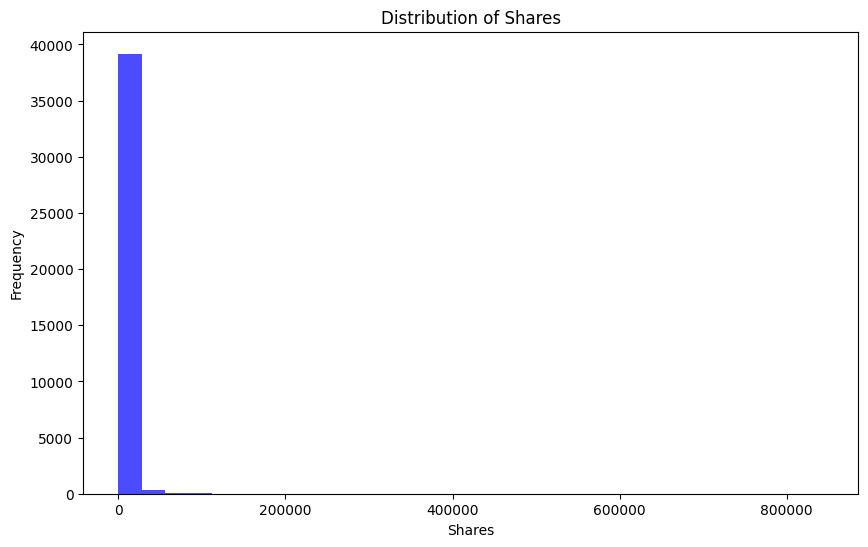

In [5]:
#1 plot the distribution of the target variable
plt.figure(figsize=(10,6))
plt.hist(df['shares'], bins=30, color='blue', alpha=0.7)
plt.title('Distribution of Shares')
plt.xlabel('Shares')
plt.ylabel('Frequency')
plt.show()

Since our histogram is showing the distribution of shares to be heavily skewed to the right, a log transformation on the target variable seems appropriate.

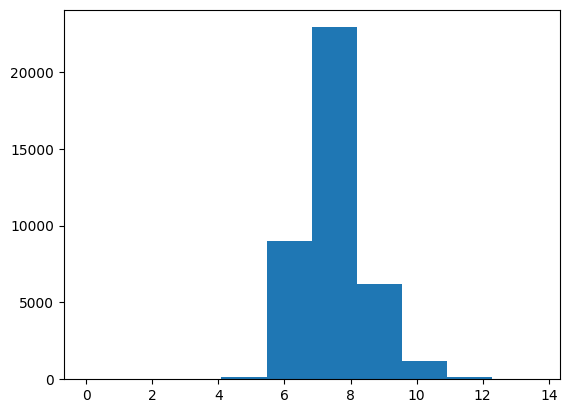

In [6]:
#1 performing a log transformation on the target variable
plt.hist(np.log(df['shares']))
plt.show()

df["log_shares"] = np.log(df['shares'])

In [45]:
#2 build a linear regression model w/o higher order
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import statsmodels.api as sm


X = df.drop(columns=["shares","log_shares", "url", "timedelta"])

# Dummify
X = pd.get_dummies(X,drop_first = True)
y = df["log_shares"]

# split into train/test groups
X_train_lin, X_test_lin, y_train_lin, y_test_lin = train_test_split(X, y, test_size=0.2, random_state=1234)

# Scale the data
scaler = StandardScaler()
scaler.fit(X_train_lin)
X_train_scaled = scaler.transform(X_train_lin)

scale_y = StandardScaler()
scale_y.fit(y_train_lin.values.reshape(-1,1))
y_train_scaled = scale_y.transform(y_train_lin.values.reshape(-1,1))

# Fit a linear regression model
reg_prep = LinearRegression()
mod_reg = reg_prep.fit(X_train_scaled,y_train_scaled)
# print(mod_reg.coef_)

#examining p-values
X_train_with_const = sm.add_constant(X_train_scaled)
X_train_with_const_df = pd.DataFrame(
    X_train_with_const, 
    columns=['const'] + list(X.columns)
)
model = sm.OLS(y_train_scaled, X_train_with_const_df).fit()
print(model.summary())

p_values = pd.DataFrame({
    'feature': X_train_with_const_df.columns,
    'p_value': model.pvalues
})

significant_features_sorted = p_values.sort_values('p_value')
top_10_significant = significant_features_sorted.head(10)

print("Top 10 most significant features:", top_10_significant)

significant_features = p_values[p_values['p_value'] < 0.05]
print("\n\n\nsignificant features with a p-value < .05", significant_features)




                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.128
Model:                            OLS   Adj. R-squared:                  0.127
Method:                 Least Squares   F-statistic:                     83.24
Date:                Mon, 09 Dec 2024   Prob (F-statistic):               0.00
Time:                        10:10:44   Log-Likelihood:                -42823.
No. Observations:               31715   AIC:                         8.576e+04
Df Residuals:                   31658   BIC:                         8.624e+04
Df Model:                          56                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

In [32]:
#r^2 for the regression model
from sklearn.metrics import mean_squared_error, r2_score
X_test_scaled = scaler.transform(X_test_lin)
preds = scale_y.inverse_transform(mod_reg.predict(X_test_scaled))
print("Out of Sample R^2: ",r2_score(y_test_lin,preds))

in_preds = scale_y.inverse_transform(mod_reg.predict(X_train_scaled))
print("In Sample R^2: ",r2_score(y_train_lin,in_preds))

Out of Sample R^2:  0.11908732172009107
In Sample R^2:  0.1283476368669546


[Text(0.5, 0.9166666666666666, 'kw_avg_avg <= 3085.189\nsquared_error = 0.868\nsamples = 31715\nvalue = 7.474'),
 Text(0.25, 0.75, 'self_reference_avg_sharess <= 1995.75\nsquared_error = 0.674\nsamples = 18796\nvalue = 7.295'),
 Text(0.375, 0.8333333333333333, 'True  '),
 Text(0.125, 0.5833333333333334, 'kw_max_max <= 654150.0\nsquared_error = 0.632\nsamples = 9894\nvalue = 7.17'),
 Text(0.0625, 0.4166666666666667, 'kw_max_avg <= 2960.399\nsquared_error = 0.679\nsamples = 2042\nvalue = 7.389'),
 Text(0.03125, 0.25, 'n_tokens_content <= 158.5\nsquared_error = 0.588\nsamples = 611\nvalue = 7.168'),
 Text(0.015625, 0.08333333333333333, 'squared_error = 0.831\nsamples = 65\nvalue = 7.599'),
 Text(0.046875, 0.08333333333333333, 'squared_error = 0.534\nsamples = 546\nvalue = 7.116'),
 Text(0.09375, 0.25, 'weekday_is_saturday <= 0.5\nsquared_error = 0.688\nsamples = 1431\nvalue = 7.483'),
 Text(0.078125, 0.08333333333333333, 'squared_error = 0.673\nsamples = 1354\nvalue = 7.453'),
 Text(0.109

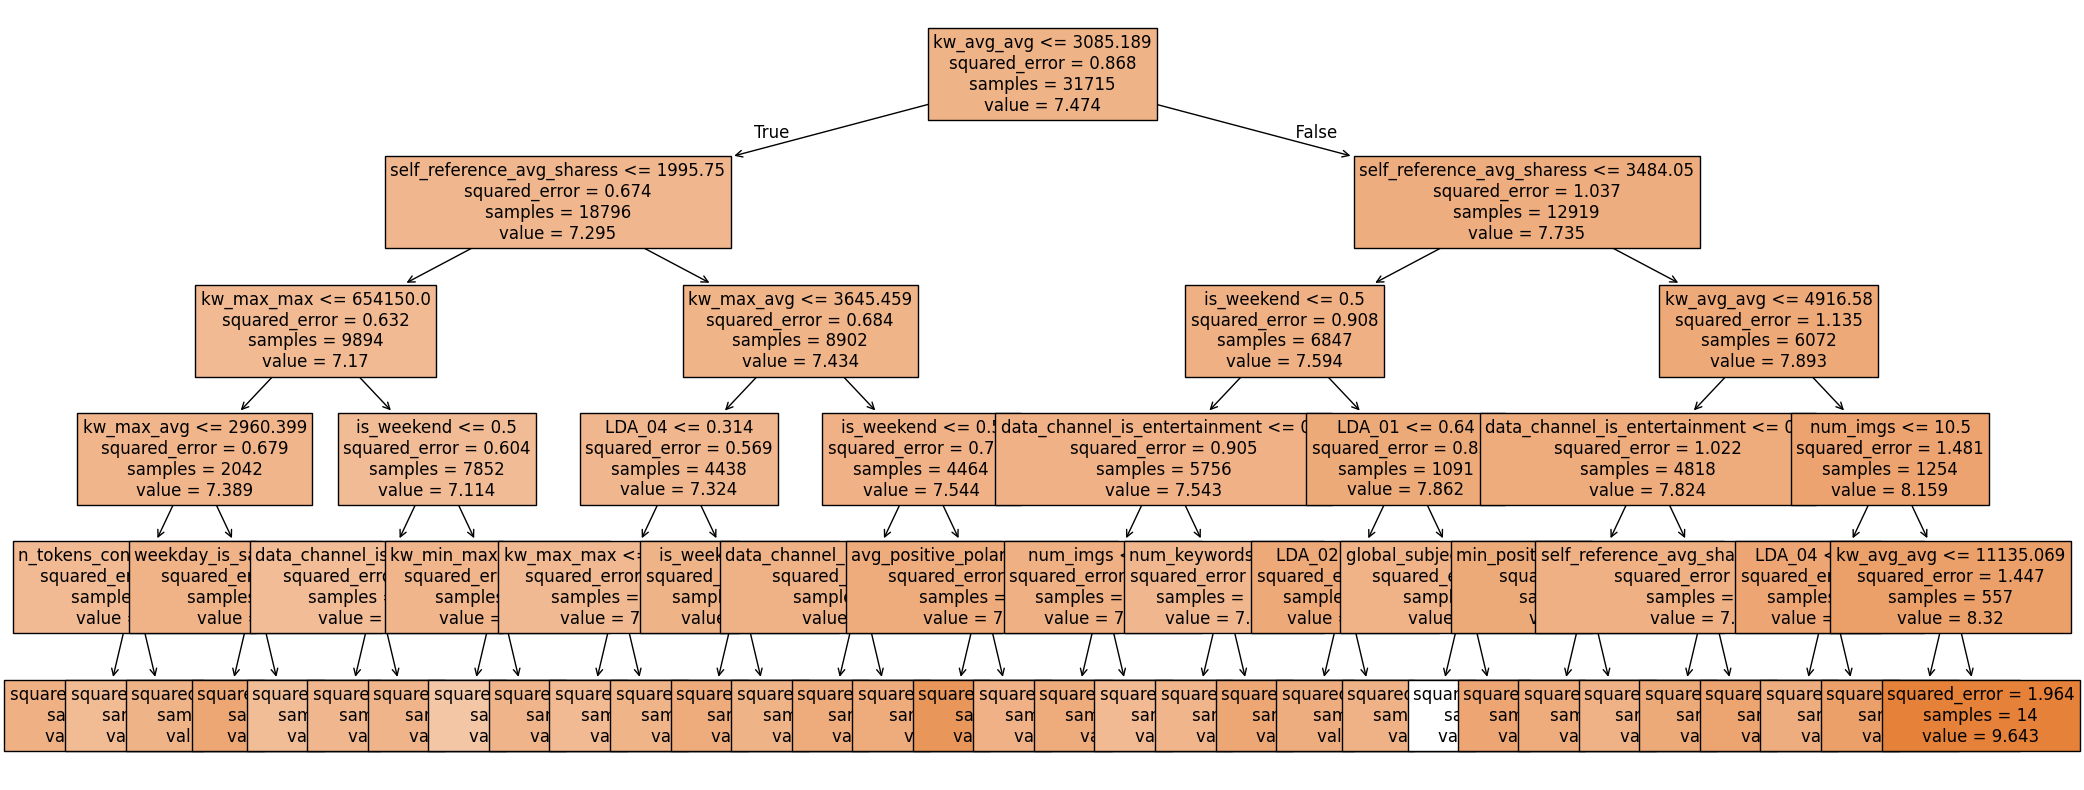

In [19]:
#3 build a regression tree
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor


predictors = df.drop(columns=["shares","log_shares", "url", "timedelta"])

# Dummify
X = pd.get_dummies(predictors,drop_first = True)
y = df["log_shares"]

# split into train/test groups
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

tree_prep = DecisionTreeRegressor(max_depth=5)
mod_tree = tree_prep.fit(X_train,y_train)
plt.figure(figsize = (25,10))
tree.plot_tree(mod_tree, feature_names=X.columns, filled = True,fontsize = 12)

In [30]:
#compare R squared
in_preds = mod_tree.predict(X_train)
in_sample = r2_score(y_train,in_preds)
print("in sample", in_sample)
preds = mod_tree.predict(X_test)
print("out of sample", r2_score(y_test,preds))


in sample 0.12416122405339514
out of sample 0.1040388227222323


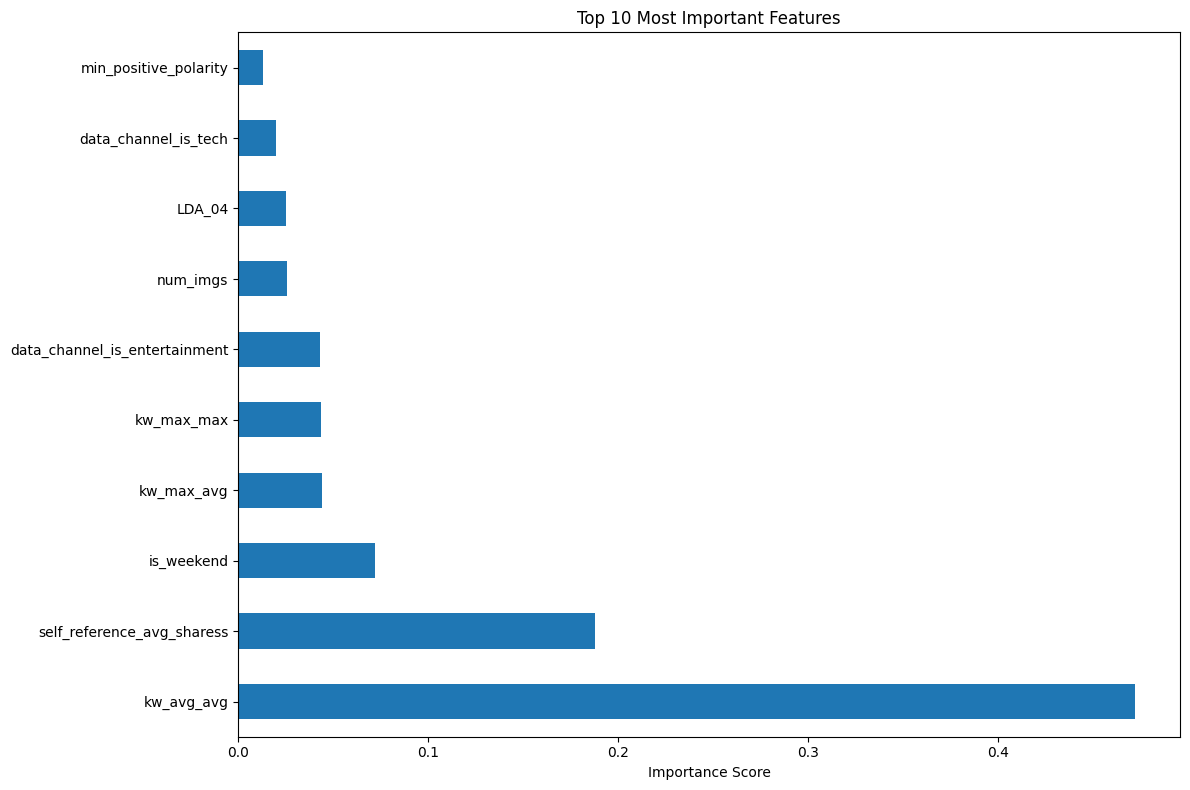


Top 10 Features by Importance:
                         Feature  Importance
0                     kw_avg_avg    0.472056
1     self_reference_avg_sharess    0.187697
2                     is_weekend    0.072200
3                     kw_max_avg    0.044079
4                     kw_max_max    0.043578
5  data_channel_is_entertainment    0.043011
6                       num_imgs    0.025721
7                         LDA_04    0.024912
8           data_channel_is_tech    0.020112
9          min_positive_polarity    0.013079


In [55]:
# Create figure
plt.figure(figsize=(12, 8))

# Create and store feature importances Series first
feature_importances = pd.Series(mod_tree.feature_importances_, index=X.columns)

# Sort and get top 10 features
top_10_features_tree = feature_importances.sort_values(ascending=False).head(10)

# Create table
feature_importance_table_tree = pd.DataFrame({
    'Feature': top_10_features_tree.index,
    'Importance': top_10_features_tree.values
})

# Plot
top_10_features_tree.plot(kind='barh')
plt.title('Top 10 Most Important Features')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

# Print table
print("\nTop 10 Features by Importance:")
print(feature_importance_table_tree)

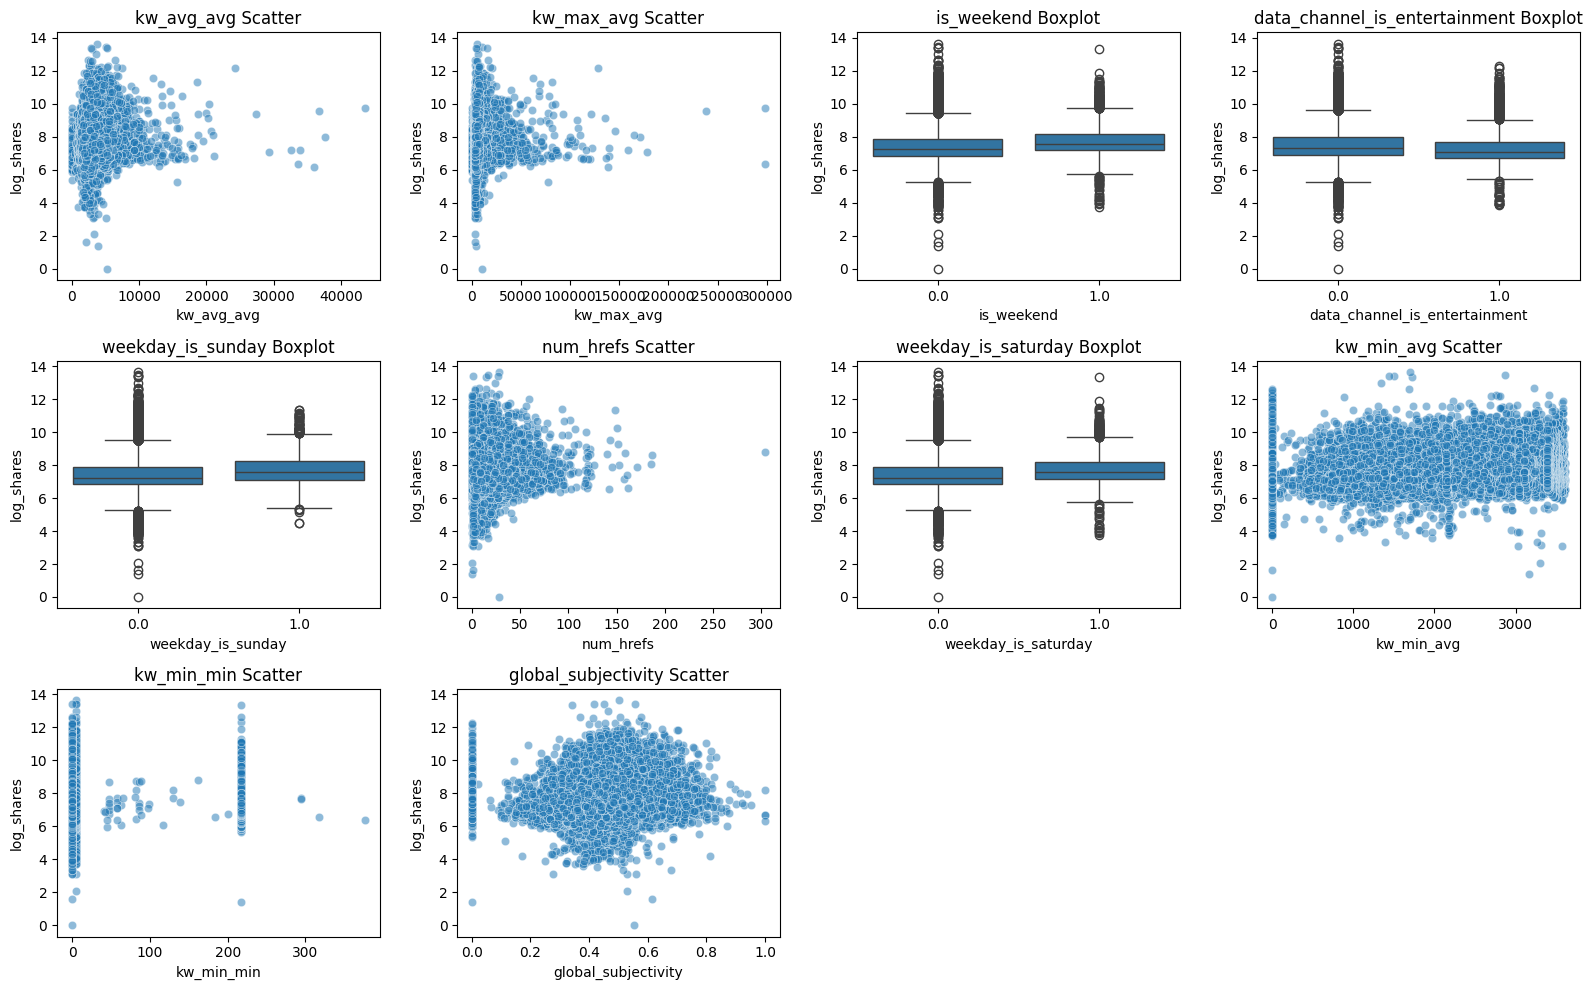

In [49]:
#4 select several significant features. create visualizations or tables to explore the relationships between features and target variable.
features = ['kw_avg_avg', 'kw_max_avg', 'is_weekend', 'data_channel_is_entertainment', 'weekday_is_sunday', 'num_hrefs', 'weekday_is_saturday', 'kw_min_avg', 'kw_min_min', 'global_subjectivity']
plt.figure(figsize=(16,10))
for i, feature in enumerate(features, 1):
    plt.subplot(3, 4, i)
    # binary
    if df[feature].nunique() <= 2:
        sns.boxplot(x=feature, y='log_shares', data=df)
        plt.title(f'{feature} Boxplot')
    #continuous
    else:
        sns.scatterplot(x=feature, y='log_shares', data=df, alpha=0.5)
        plt.title(f'{feature} Scatter')
plt.tight_layout()
plt.show()

In [ ]:
#6 use appropriate methods to remove insignificant variable froms the model.

#removed all predictors with p-values > 0.05
mod_temp = model
X_train_temp = X_train_with_const_df

while max(mod_temp.pvalues[1:]) > 0.05 and (len(X_train_temp.columns) > 1):
  max_pvalue = np.argmax(mod_temp.pvalues[1:])+1
  X_train_temp = X_train_temp.drop(columns = X_train_temp.columns[max_pvalue])
  mod_temp = sm.OLS(y_train_scaled,X_train_temp).fit()

mod_reduced = mod_temp
mod_temp.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.128
Model:                            OLS   Adj. R-squared:                  0.127
Method:                 Least Squares   F-statistic:                     118.9
Date:                Mon, 09 Dec 2024   Prob (F-statistic):               0.00
Time:                        10:07:10   Log-Likelihood:                -42834.
No. Observations:               31715   AIC:                         8.575e+04
Df Residuals:                   31675   BIC:                         8.608e+04
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                         -5.448e-16      0.005  -1.04e-13      1.000      -0.010       0.010
n_tokens_title                    0.0111      0.005      2.029      0.042       0.000       0.022
n_tokens_content                  0.0215      0.007      3.236      0.001       0.008       0.035
n_non_stop_words                  0.0116      0.005      2.202      0.028       0.001       0.022
num_hrefs                         0.0563      0.007      8.376      0.000       0.043       0.070
num_self_hrefs                   -0.0321      0.006     -5.266      0.000      -0.044      -0.020
num_imgs                          0.0257      0.006      4.181      0.000       0.014       0.038
average_token_length             -0.0715      0.009     -7.935      0.000      -0.089      -0.054
num_keywords                      0.0244      0.006      3.853      0.000       0.012       0.037
data_channel_is_lifestyle        -0.0199      0.007     -2.931      0.003      -0.033      -0.007
data_channel_is_entertainment    -0.0651      0.008     -8.385      0.000      -0.080      -0.050
data_channel_is_bus              -0.0578      0.010     -5.522      0.000      -0.078      -0.037
data_channel_is_socmed            0.0453      0.007      6.957      0.000       0.033       0.058
data_channel_is_tech              0.0597      0.010      5.986      0.000       0.040       0.079
kw_min_min                        0.0611      0.007      9.044      0.000       0.048       0.074
kw_max_min                        0.0694      0.017      4.039      0.000       0.036       0.103
kw_avg_min                       -0.0894      0.017     -5.275      0.000      -0.123      -0.056
kw_min_max                       -0.0145      0.006     -2.366      0.018      -0.026      -0.002
kw_avg_max                       -0.0505      0.009     -5.339      0.000      -0.069      -0.032
kw_min_avg                       -0.0601      0.008     -7.707      0.000      -0.075      -0.045
kw_max_avg                       -0.2781      0.014    -20.008      0.000      -0.305      -0.251
kw_avg_avg                        0.4793      0.017     28.186      0.000       0.446       0.513
self_reference_avg_sharess        0.0473      0.005      8.790      0.000       0.037       0.058
weekday_is_tuesday               -0.0274      0.006     -4.575      0.000      -0.039      -0.016
weekday_is_wednesday             -0.0279      0.006     -4.650      0.000      -0.040      -0.016
weekday_is_thursday              -0.0233      0.006     -3.892      0.000      -0.035      -0.012
weekday_is_saturday               0.0293      0.004      6.940      0.000       0.021       0.038
weekday_is_sunday                 0.0285      0.004      6.977      0.000       0.020       0.037
is_weekend                        0.0423     

**Technical Report**

EDA SECTION

- We performed a log transformation on the target variable shares to make it less skewed. Binary features were examined using boxplots to explore their relationship with log_shares and scatterplots were used to explore the relationship between continuous features and log_shares.

- Results: 
    - The out of sample R^2 for our linear regression model was: 0.11908732172009107
    - The out of sample R^2 for our regression tree was: 0.1040388227222323
    A higher R^2 suggests that the model is better at predicting the target variable. From our results, our initial linear regression model was slightly better than our regression tree model at predicting the target variable of log_shares although the models were comparable.

    - Below is a table with the 10 most significant features from our linear regression model (features with p-vaues less than .05) and the 10 features of most importance from our intial regression tree model.
    - The features that we noticed the same for both include: kw_avg_avg, kw_max_avg, is_weekend and data_channel_is_entertainment.





In [56]:
print("Top 10 most significant features in initial linear regression model:", top_10_significant)

print("\nTop 10 Features by Importance:")
print(feature_importance_table_tree)

Top 10 most significant features in initial linear regression model:                          Feature    P-value
0                     kw_avg_avg  5.12e-164
1                     kw_max_avg   1.18e-84
2                     is_weekend   2.25e-72
3  data_channel_is_entertainment   5.18e-16
4              weekday_is_sunday   2.52e-15
5                      num_hrefs   4.42e-15
6            weekday_is_saturday   7.64e-15
7                     kw_min_avg   2.54e-14
8                     kw_min_min   1.91e-10
9            global_subjectivity   3.98e-10

Top 10 Features by Importance:
                         Feature  Importance
0                     kw_avg_avg    0.472056
1     self_reference_avg_sharess    0.187697
2                     is_weekend    0.072200
3                     kw_max_avg    0.044079
4                     kw_max_max    0.043578
5  data_channel_is_entertainment    0.043011
6                       num_imgs    0.025721
7                         LDA_04    0.024912
8         